Here we have different methods to understand the feature importance to do dimenssionality reduction and feature selection. <br>
These methods are: <br>
1 - correlation_matrix (comapring the methods: Spearman, pearson, Kendall) -- we used finally Kendall
2 - shapiro <br>
3 - scatterplot <br>
4 - Principal Component Analysis (PCA) <br>
5 - Feature importance method in tree-based training models such as Random Forest <br>
6 - SelectKBest <br>
7 - Permutation_importance <br>
8 - Shapley values of trained model by an algorithm such as LinearRegression <br>

In [1]:
# Imports
import numpy as np
import pandas as pd
import scipy
import subprocess
from sklearn import metrics
import csv
import sklearn
import shap
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import DataGenerator, KneeLocator 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import TypedDict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Check columns importance in final_episodes

In [2]:
# read the data
final_episodes = pd.read_csv("/home/kabank/workbench/.conda/analysis/kabank-data/new-data/final_episodes.csv")

# required changes *****
final_episodes.rename(columns={'var_no_dates_permonth': 'SD_CareEvent_PerMonth'}, inplace=True)

final_episodes.loc[final_episodes['age_group'] == 'Preschooler', 'age_group'] = 0
final_episodes.loc[final_episodes['age_group'] == 'MiddleChildhood', 'age_group'] = 1
final_episodes.loc[final_episodes['age_group'] == 'Teenager', 'age_group'] = 2

final_episodes.loc[final_episodes['gender'] == '0', 'gender'] = 0
final_episodes.loc[final_episodes['gender'] == 'F', 'gender'] = 1
final_episodes.loc[final_episodes['gender'] == 'M', 'gender'] = 2



final_episodes = final_episodes[['gender', 'age_group','Length_of_Episode','Count_visit','SD_CareEvent_PerMonth','Care_intensity', 'num_diagnoses', 'num_medications',
       'Inpatient_day_ratio', 'Outpatient_ratio', 'Therapy_ratio','TreatmentPlanning_ratio','Examination_ratio', 'Advisory_ratio','tillnextepisode']]

# final_episodes = final_episodes[['gender', 'age_group','Length_of_Episode','Count_visit','SD_CareEvent_PerMonth', 'num_diagnoses', 'num_medications',
#        'Inpatient_day_ratio', 'Outpatient_ratio', 'Therapy_ratio','TreatmentPlanning_ratio', 'Advisory_ratio','tillnextepisode']]

final_episodes.rename(columns={'num_diagnoses': 'Num_diagnoses'}, inplace=True)
final_episodes.rename(columns={'num_medications': 'Num_medications'}, inplace=True)
final_episodes.rename(columns={'age_group': 'Age_group'}, inplace=True)
final_episodes.rename(columns={'gender': 'Gender'}, inplace=True)
final_episodes.rename(columns={'label': 'Label'}, inplace=True)

final_episodes.dropna()
print(len(final_episodes), len(final_episodes.columns))
final_episodes.columns

22676 15


Index(['Gender', 'Age_group', 'Length_of_Episode', 'Count_visit',
       'SD_CareEvent_PerMonth', 'Care_intensity', 'Num_diagnoses',
       'Num_medications', 'Inpatient_day_ratio', 'Outpatient_ratio',
       'Therapy_ratio', 'TreatmentPlanning_ratio', 'Examination_ratio',
       'Advisory_ratio', 'tillnextepisode'],
      dtype='object')

In [3]:
final_episodes['tillnextepisode'].count()

3426

In [4]:
final_episodes.rename(columns={'tillnextepisode': 'Tillnextepisode'}, inplace=True)

In [5]:
final_episodes.rename(columns={'Label': 'Bin_Labels'}, inplace=True)

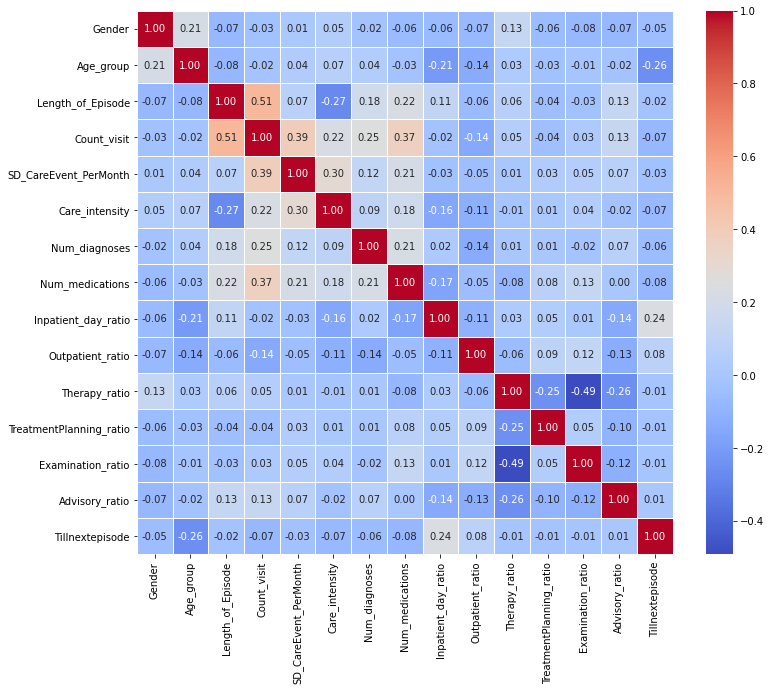

In [7]:
# Considering some facts: 
# As the relationship between the features and the label might be non-linear, correlation may not accurately reflect the importance of features. 
# Correlation focuses on pairwise relationships. A feature might not show high correlation individually but might be crucial when combined with other features.

# Check for correlation matrix with the features in their original scale
# While we are unsure about the distribution of our data (might not be normal), the relationships between variables might not be linear and suspect the presence of outliers, Spearman or Kendall correlations might be more appropriate. 
#correlation_matrix_original = final_episodes.corr(method='pearson')
correlation_matrix_original = final_episodes.corr(method='kendall')
# Visualize correlation matrix if needed
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_original, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
#plt.savefig("/home/kabank/CAMHS_Readmission_Analytics/Paper_figures/correlation_matrix_kendall.png", dpi=300)
plt.show()

In [8]:
from scipy.stats import shapiro

for col in final_episodes.columns:
    _, p = shapiro(final_episodes[col])
    if p > 0.05:
        print(f'{col} looks Gaussian (fail to reject H0)')
    else:
        print(f'{col} does not look Gaussian (reject H0)')

Gender does not look Gaussian (reject H0)
Age_group does not look Gaussian (reject H0)
Length_of_Episode does not look Gaussian (reject H0)
Count_visit does not look Gaussian (reject H0)
SD_CareEvent_PerMonth does not look Gaussian (reject H0)
Care_intensity does not look Gaussian (reject H0)
Num_diagnoses looks Gaussian (fail to reject H0)
Num_medications looks Gaussian (fail to reject H0)
Inpatient_day_ratio looks Gaussian (fail to reject H0)
Outpatient_ratio looks Gaussian (fail to reject H0)
Therapy_ratio looks Gaussian (fail to reject H0)
TreatmentPlanning_ratio looks Gaussian (fail to reject H0)
Examination_ratio looks Gaussian (fail to reject H0)
Advisory_ratio looks Gaussian (fail to reject H0)
Tillnextepisode looks Gaussian (fail to reject H0)


p-value may not be accurate for N > 5000.


In [9]:
# Encoding 'tillnextepisode' into labels:  
le = LabelEncoder()
final_episodes['Bin_Labels'] = le.fit_transform(pd.cut(final_episodes['Tillnextepisode'],
                                                  bins=[float('-inf'), 0, 180, 365, 730, 1095, float('inf')],
                                                  labels=['not-re-admitted',
                                                          're-admitted in 0-180 days',
                                                          're-admitted in 180-365 days',
                                                          're-admitted in 365-730 days',
                                                          're-admitted in 730-1095 days',
                                                          're-admitted in more than 1095 days']))

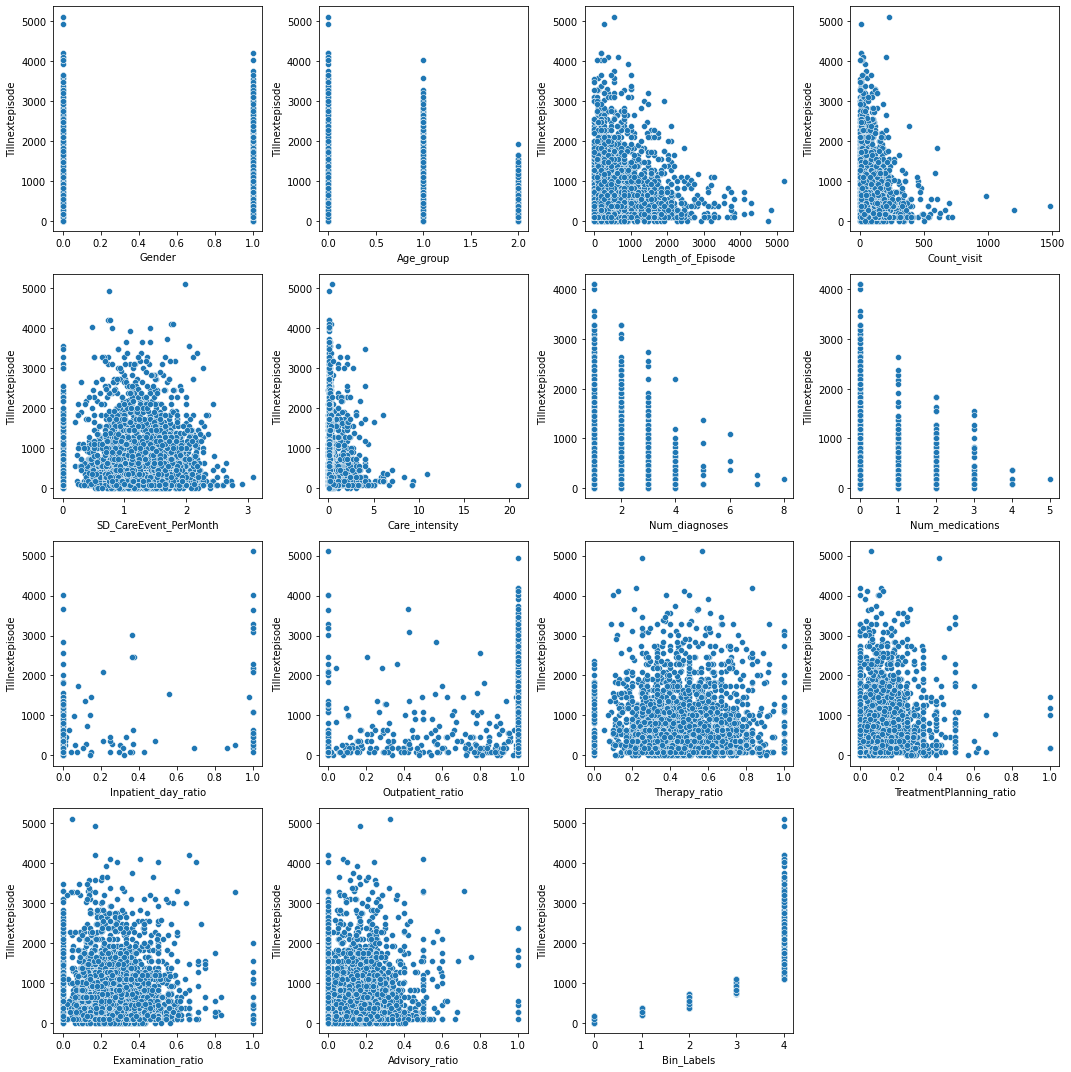

In [11]:
features = ['Gender', 'Age_group', 'Length_of_Episode', 'Count_visit',
       'SD_CareEvent_PerMonth', 'Care_intensity', 'Num_diagnoses',
       'Num_medications', 'Inpatient_day_ratio', 'Outpatient_ratio',
       'Therapy_ratio', 'TreatmentPlanning_ratio', 'Examination_ratio',
       'Advisory_ratio', 'Bin_Labels']
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    sns.scatterplot(data=final_episodes, x=feature, y='Tillnextepisode', ax=axs[row, col])
    #axs[row, col].set_title(feature)

# Remove empty subplots
for i in range(len(features), 16):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
#plt.savefig("/home/kabank/CAMHS_Readmission_Analytics/Paper_figures/scatterplot_All_Features.png", dpi=300)
plt.show()

# Using final_episodes and applying PCA for feature reduction

In [24]:
episodes_df = final_episodes.copy()
y = final_episodes['Tillnextepisode']
episodes_df.drop(columns='Tillnextepisode', inplace=True)
episodes_df.fillna(0, inplace=True)
print(episodes_df.columns)

# Do PCA from basis
X = episodes_df
# Standardizing the data in PCA to ensure that all features have the same scale:
X = StandardScaler().fit_transform(X)
X_mean = np.mean(X, axis=0)

# The covariance matrix is a square matrix representing the covariance between each pair of features:
#cov_mat = np.cov(X)
cov_mat = (X - X_mean).T.dot((X - X_mean)) / (X.shape[0]-1)
print('Covariance matrix: \n%s' %cov_mat)

Index(['Gender', 'Age_group', 'Length_of_Episode', 'Count_visit',
       'SD_CareEvent_PerMonth', 'Care_intensity', 'Num_diagnoses',
       'Num_medications', 'Inpatient_day_ratio', 'Outpatient_ratio',
       'Therapy_ratio', 'TreatmentPlanning_ratio', 'Examination_ratio',
       'Advisory_ratio', 'Bin_Labels'],
      dtype='object')
Covariance matrix: 
[[ 1.0000441   0.20170203 -0.08613848 -0.00949491  0.014722    0.04027372
  -0.0137837  -0.03438181 -0.00479156 -0.05105943  0.14594005 -0.06139708
  -0.07979468 -0.0713056  -0.00732383]
 [ 0.20170203  1.0000441  -0.11284959 -0.02246177  0.05411554  0.01940465
   0.07858926  0.01011323 -0.03841969 -0.12148038 -0.00380638 -0.03283322
   0.03180499 -0.00971455  0.0851921 ]
 [-0.08613848 -0.11284959  1.0000441   0.44628727 -0.00484018 -0.22782349
   0.30773392  0.21960381  0.06792114 -0.01043699  0.05754692 -0.08191013
  -0.06157328  0.05743649  0.04962598]
 [-0.00949491 -0.02246177  0.44628727  1.0000441   0.33254918 -0.03703395
   0.4373

In [25]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# print('Eigenvectors \n%s' %eig_vecs)
# print('\nEigenvalues \n%s' %eig_vals)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
   print(i[0])

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp
# In the array bellow we see that the first feature explains roughly 9.6% of the variance within our data set 
# to have the 95% of the variance we need to have the first 24 features

Eigenvalues in descending order:
2.4240833621319133
1.7828675547533337
1.4541120219510697
1.3196240727060107
1.1631424394451273
1.1293055436383277
1.0187470903437263
0.9994056890469226
0.862057462633939
0.7686937591089461
0.6640118037854146
0.563001075517495
0.5381145238347039
0.3090566032252961
0.004438519377241988


array([ 16.15984308,  28.04510262,  37.73875526,  46.53586111,
        54.28980208,  61.81817369,  68.60952145,  75.27193223,
        81.01872854,  86.1431276 ,  90.56967774,  94.32285273,
        97.91012468,  99.97041118, 100.        ])

In [ ]:
#Principal Component Analysis (PCA):
#Transform the data into a lower-dimensional space while retaining as much information as possible. 
# The first few principal components often capture most of the variance.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

# optional but recommended for PCA to do data standardization
scaler = StandardScaler() #  to ensure that each feature has zero mean and unit variance.
episodes_scaled = scaler.fit_transform(episodes_df)

# Apply PCA to reduce dimensionality while retaining most of the variance
# We may need to experiment with different values of n_components to find the right balance between dimensionality reduction and information retention.
n_components = 13 # Number of components 
pca = PCA(n_components=n_components)
episodes_pca = pca.fit_transform(episodes_scaled)

# episodes_pca now contains the transformed data with reduced dimensionality

# Explained variance ratio to see how much variance is retained
# Help us to understand how well the reduced-dimensional representation captures the variability in the original data.
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Explained Variance Ratio: {explained_variance_ratio}')

# To use the transformed data for clustering or prediction tasks, we can use episodes_pca
#ratio of the total variance in the original data
#Understanding the explained variance ratio is important because it helps you determine how many principal components to retain.
#  You generally want to retain enough components to capture a high percentage of the total variance, while reducing the dimensionality of the data.

Explained Variance Ratio: [0.18503965 0.11290876 0.10121296 0.08943326 0.08840349 0.08007869
 0.07102819 0.06321295 0.05191963 0.04856892 0.04314373 0.04132309
 0.02372669]


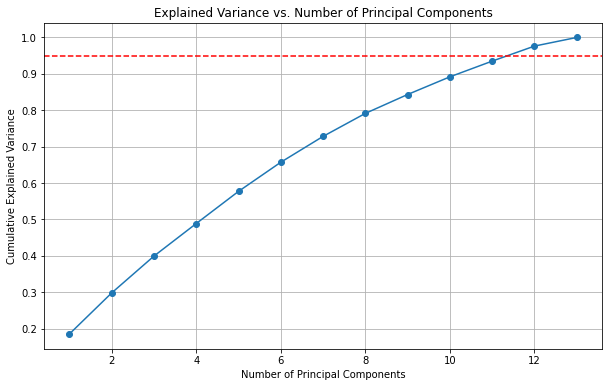

In [ ]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)
                                
# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o')
plt.title('Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
#We want to pick the smallest k so that k-dimensional space gives you %95 variance.
# Optionally, draw a horizontal line at a specific threshold (e.g., 0.95 for 95% variance)
plt.axhline(y=0.95, color='r', linestyle='--')

# Show the plot
plt.show()


In [ ]:
# Assuming pca is your PCA object after fitting
# the loadings, represent the weights of the original features in each principal component.
loadings = pca.components_

# Each row of 'loadings' corresponds to a principal component
# Each column corresponds to an original feature

# To get the most important features for the first principal component:
top_features_first_component = loadings[0]

# You can sort the features by their absolute values to see the most influential ones
sorted_features_indices = abs(top_features_first_component).argsort()[::-1]
top_features_names = episodes_df.columns[sorted_features_indices]

print(f'Top features for first principal component: {top_features_names}')
# they are sorted based on their importance (loadings) in the first principal component: the most influential features

Top features for first principal component: Index(['Count_visit', 'Num_diagnoses', 'Num_medications', 'Length_of_Episode',
       'Intensity_per_calendar_month', 'Care_intensity',
       'TreatmentPlanning_ratio', 'Advisory_ratio', 'Outpatient_ratio',
       'Examination_ratio', 'Gender', 'Inpatient_day_ratio', 'Age_group'],
      dtype='object')


# Correlation Analysis

# Tree-Based Models Feature Importance:
Train a tree-based model (e.g., Random Forest, Gradient Boosting) and use the built-in feature importance attribute.

In [ ]:
X = episodes_df
y= final_episodes['tillnextepisode']

# Remove rows with NaN in the target variable
X = X[~y.isna()]
y = y.dropna()

model = RandomForestRegressor()
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance


Count_visit                     0.128974
Age_group                       0.121116
Examination_ratio               0.120847
Care_intensity                  0.110761
Advisory_ratio                  0.108504
Intensity_per_calendar_month    0.108416
TreatmentPlanning_ratio         0.106844
Length_of_Episode               0.104104
Num_diagnoses                   0.027880
Inpatient_day_ratio             0.023085
Gender                          0.021373
Outpatient_ratio                0.011923
Num_medications                 0.006174
dtype: float64

# SelectKBest and Feature Importance:
Use statistical tests (e.g., ANOVA, chi-squared) to select the top k features.

In [ ]:
selector = SelectKBest(f_classif, k='all')
# X_new, only includes the ‘k’ best features.
X_new = selector.fit_transform(X, y)
feature_scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False)
feature_scores


Inpatient_day_ratio             2.841292
Age_group                       1.994079
Care_intensity                  1.791786
Advisory_ratio                  1.438441
Outpatient_ratio                1.412125
Intensity_per_calendar_month    1.168446
TreatmentPlanning_ratio         1.155092
Examination_ratio               1.086696
Gender                          1.059798
Length_of_Episode               0.921463
Num_diagnoses                   0.856323
Count_visit                     0.731931
Num_medications                 0.675441
dtype: float64

# Permutation Feature Importance:
Randomly shuffle values of a single feature and measure the impact on the model's performance.

In [ ]:
result = permutation_importance(model, X, y, n_repeats=10, random_state=0)
perm_importance = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
perm_importance


Age_group                       0.766142
Count_visit                     0.455021
Examination_ratio               0.247630
Length_of_Episode               0.241124
TreatmentPlanning_ratio         0.239000
Intensity_per_calendar_month    0.222447
Advisory_ratio                  0.218247
Care_intensity                  0.188832
Gender                          0.071372
Num_diagnoses                   0.061043
Inpatient_day_ratio             0.027365
Outpatient_ratio                0.023579
Num_medications                 0.016926
dtype: float64

# Shapley values for feature selection
contribution of each feature in a model’s prediction.
it helps interpret which features have a high influence on the prediction

In [ ]:
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution
# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

# print model coefficients - It then prints the coefficients learned for each feature, which tell us how much the model output changes when we change each of the input features
print("Model coefficients:\\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))


Model coefficients:\n
Gender = 31.71235
Age_group = -395.70791
Length_of_Episode = -0.19141
Count_visit = -0.25824
Num_diagnoses = -5.5289
Num_medications = -38.54485
Inpatient_day_ratio = 640.88476
Intensity_per_calendar_month = -22.21649
Care_intensity = -34.76583
Outpatient_ratio = 61.71537
Examination_ratio = -12.09601
TreatmentPlanning_ratio = -196.5872
Advisory_ratio = 202.88359


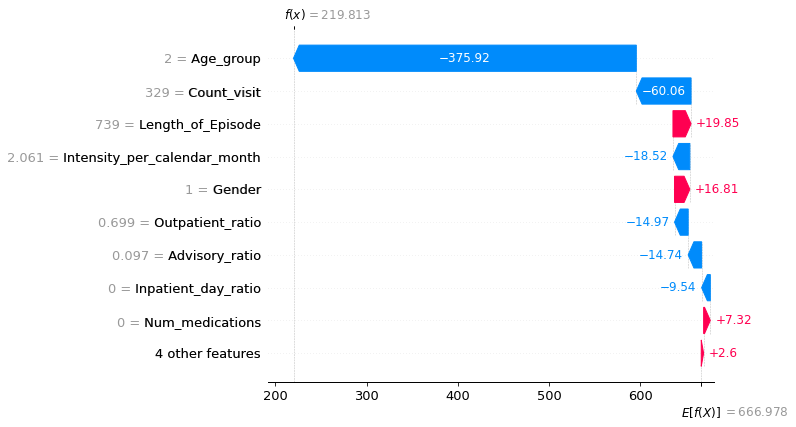

<Figure size 432x288 with 0 Axes>

In [ ]:
# explain all the predictions in the test set
explainer = shap.Explainer(model, X100)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
# get the current figure
fig = plt.gcf()

# change the color of all text elements to white
for text in fig.findobj(plt.Text):
    text.set_color('white')

# show the plot
plt.show()
